In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider
from scipy.optimize import curve_fit

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

from numpy.polynomial import Chebyshev

from scipy.special import erf

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

**this is the backup version 1.3**

1. Break up each code module into cells and explain with physical meaning.
2. Remove original modules, and intigrate functions: options for step, options for width cretiria, spherical aberr.

## 1. Data Import

### 1.1 Import Defocus-Wavelength Data

Import Zemax defocus data for wavelengths from 400 nm to 700 nm to model longitudinal chromatic aberration in an optical system.

The data is stored in a NumPy array where each row contains two values: the wavelength (nm) and the corresponding defocus (µm).

In [2]:
# CHLzf85 data points
# Each row contains [wavelength (nm), defocus (µm)]
CHLzf85 = np.array([
    [400.0, 285.0],
    [410.0, 190.0],
    [420.0, 118.0],
    [430.0, 63.0],
    [440.0, 22.0],
    [450.0, -9.0],
    [460.0, -31.0],
    [470.0, -46.0],
    [480.0, -56.0],
    [490.0, -62.0],
    [500.0, -64.0],
    [510.0, -63.0],
    [520.0, -60.0],
    [530.0, -54.0],
    [540.0, -48.0],
    [550.0, -39.0],
    [560.0, -30.0],
    [570.0, -20.0],
    [580.0, -9.0],
    [590.0, 3.0],
    [600.0, 15.0],
    [610.0, 28.0],
    [620.0, 41.0],
    [630.0, 54.0],
    [640.0, 68.0],
    [650.0, 82.0],
    [660.0, 96.0],
    [670.0, 111.0],
    [680.0, 125.0],
    [690.0, 139.0],
    [700.0, 156.0]
])

### 1.2 Import Sensor and Light Source Data

Load additional spectral data for optical imaging analysis.

These spectra define the effective weighting of each wavelength in imaging, as the final image intensity is determined by the sensor response, light source, and optical transmission. For evaluating chromatic aberrations, the weighting spectrum for each color channel $ i $ ($ R $, $ G $, or $ B $) is defined as:

$$
g_i(\lambda) = s_i(\lambda) \cdot q(\lambda) \cdot t(\lambda)
$$

Where:
- $s_i(\lambda)$ is the spectral sensor response for channel \( i \).
- $q(\lambda)$ is the spectral source distribution.
- $t(\lambda)$ is the lens transmission, here assumed to be 1.

In [3]:
# Light Source Data
# Each row contains [wavelength (nm), daylight value]
or_Daylight = np.array([
    [380, 11],
    [390, 16],
    [400, 22],
    [410, 33],
    [420, 48],
    [430, 62],
    [440, 71],
    [450, 78],
    [460, 84],
    [470, 92],
    [480, 97],
    [490, 100],
    [500, 96],
    [510, 95],
    [520, 95],
    [530, 94],
    [540, 90],
    [550, 78],
    [560, 70],
    [570, 78],
    [580, 88],
    [590, 94],
    [600, 91],
    [610, 85],
    [620, 82],
    [630, 85],
    [640, 92],
    [650, 100],
    [660, 89],
    [670, 76],
    [680, 83],
    [690, 100]
])

# Optional: Print the shape and first few rows for verification
print("Original Daylight Spectrum shape:", or_Daylight.shape)

Original Daylight Spectrum shape: (32, 2)


In [4]:
# Sensor data for each channel:
# Each row contains [wavelength (nm), sensitivity]
SensorBlue = np.array([
    [400., 0.42],
    [410., 9.08],
    [420., 24.34],
    [430., 28.37],
    [440., 40.12],
    [450., 39.01],
    [460., 47.12],
    [470., 46.65],
    [480., 41.14],
    [490., 26.73],
    [500., 14.75],
    [510., 7.55],
    [520., 2.76],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 0.],
    [580., 0.],
    [590., 0.],
    [600., 0.],
    [610., 0.],
    [620., 0.],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.84],
    [680., 0.32],
    [690., 0.04],
    [700., 0.]
])

SensorGreen = np.array([
    [400., 0.],
    [410., 0.],
    [420., 0.],
    [430., 0.],
    [440., 0.],
    [450., 0.],
    [460., 0.],
    [470., 4.63],
    [480., 6.48],
    [490., 9.09],
    [500., 17.75],
    [510., 28.39],
    [520., 37.8],
    [530., 38.39],
    [540., 35.02],
    [550., 28.83],
    [560., 28.1],
    [570., 19.02],
    [580., 13.1],
    [590., 6.96],
    [600., 4.33],
    [610., 3.34],
    [620., 3.02],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.7],
    [680., 0.34],
    [690., 0.05],
    [700., 0.]
])

SensorRed = np.array([
    [400., 0.],
    [410., 1.3],
    [420., 1.86],
    [430., 2.17],
    [440., 1.73],
    [450., 0.],
    [460., 0.],
    [470., 0.],
    [480., 0.],
    [490., 0.],
    [500., 0.],
    [510., 0.],
    [520., 0.],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 2.38],
    [580., 60.18],
    [590., 100.],
    [600., 92.73],
    [610., 72.75],
    [620., 50.6],
    [630., 35.81],
    [640., 35.08],
    [650., 22.4],
    [660., 16.96],
    [670., 7.75],
    [680., 3.3],
    [690., 0.78],
    [700., 0.18]
])

# Optional: Print sensor data shapes to confirm successful import
print("SensorBlue shape:", SensorBlue.shape)
print("SensorGreen shape:", SensorGreen.shape)
print("SensorRed shape:", SensorRed.shape)

SensorBlue shape: (31, 2)
SensorGreen shape: (31, 2)
SensorRed shape: (31, 2)


Although individual channel data (Blue, Green, and Red) provide the spectral sensitivity for each color separately, sensor total data represents the overall sensor response when all channels are combined. This composite measurement is essential for calibrating and fitting the individual channel models, ensuring that their combined output accurately reproduces the total sensor response and that the final image intensity reflects the true behavior of the sensor.

In [5]:
# SensorTotal data for fitting:
# Each row contains [wavelength (nm), total sensor response value]
SensorTotal = np.array([
    [400, 0.00575498651873479],
    [410, 0.13598725582740515],
    [420, 0.3500690684259469],
    [430, 0.40804851719416124],
    [440, 0.5651351405209354],
    [450, 0.5345286287996289],
    [460, 0.6456546780066269],
    [470, 0.7123935338849308],
    [480, 0.6661335648527817],
    [490, 0.509934788098398],
    [500, 0.48265533396893734],
    [510, 0.5521677813325649],
    [520, 0.6352622586348873],
    [530, 0.6067689564250143],
    [540, 0.553504789111852],
    [550, 0.45566941947728984],
    [560, 0.44413148412458714],
    [570, 0.3218004034152092],
    [580, 0.7426492984019468],
    [590, 1.0],
    [600, 0.8937292232977762],
    [610, 0.7002609893330851],
    [620, 0.4980694870649698],
    [630, 0.31870702306489324],
    [640, 0.3122100633654413],
    [650, 0.19935876338044142],
    [660, 0.17130340412862252],
    [670, 0.09154831881506421],
    [680, 0.03912840235676034],
    [690, 0.008280320438011262],
    [700, 0.0016019900628785474]
])
# Optional: Print the shape and first few rows to confirm successful import
print("SensorTotal shape:", SensorTotal.shape)

SensorTotal shape: (31, 2)


## 2. Data Fitting and Common Sampling Scheme

### 2.1 Interpolation onto a Common Scheme

All datasets (defocus, sensor sensitivity, and light source spectrum) are fit and resampled onto a common 400–700 nm grid to ensure consistency in subsequent calculations.

#### 1. CHL Data Fit: Polynomial of Degree 6

**Description:**  
Fit a 6th-degree polynomial to CHL data (400–700 nm) to quantify the lens's chromatic aberration.

**Inputs:**  
- **x_CHL:** Wavelength values from `CHLzf85` (31 points, 400–700 nm).  
- **y_CHL:** Corresponding CHL measurements.  
- **x_fit:** 300-point wavelength grid from 400 to 700 nm.

**Method:**  
- Use `np.polyfit` to compute polynomial coefficients from (x_CHL, y_CHL).  
- Define `CHLFit(x)` using `np.polyval` for interpolation.

**Outputs:**  
- **CHL_coeffs:** Fitted polynomial coefficients.  
- **CHLFit(x):** Function returning polynomial values at any wavelength.  
- **CHL_fit:** Resampled data, the evaluated polynomial values on the common grid.

In [6]:
# CHL fit: polynomial of degree 6

# x_CHL contains the wavelength values and y_CHL the corresponding CHL values from the dataset CHLzf85.
x_CHL = CHLzf85[:, 0]
y_CHL = CHLzf85[:, 1]

# Fit a 6th-degree polynomial to the CHL data
CHL_coeffs = np.polyfit(x_CHL, y_CHL, 6)

# Define a function to evaluate the fitted polynomial at any given x (wavelength)
def CHLFit(x):
    # np.polyval evaluates the polynomial for the input x using coefficients in descending order
    return np.polyval(CHL_coeffs, x)

# Optional: Print the coefficients for inspection
print("Fitted CHL coefficients:", CHL_coeffs)

x_fit = np.linspace(400, 700, 300)
CHL_fit = CHLFit(x_fit)
print("Fitted CHL shape:", CHL_fit.shape)

Fitted CHL coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]
Fitted CHL shape: (300,)


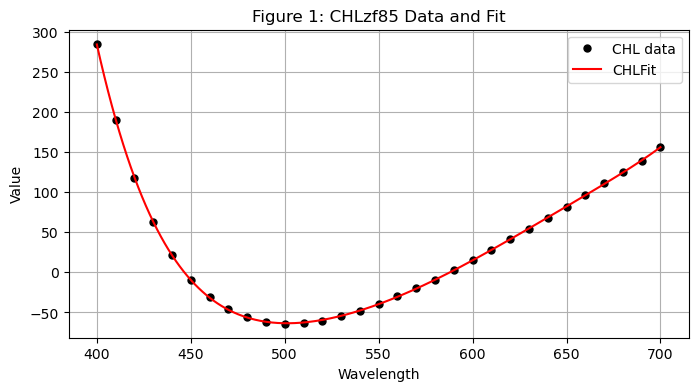

In [7]:
# Figure 1: CHLzf85 plot (points and line)
plt.figure(figsize=(8, 4))
plt.plot(x_CHL, y_CHL, 'o', markersize=5, color='black', label='CHL data') # Points in black

plt.plot(x_fit, CHL_fit, '-', color='red', label='CHLFit') # Curve in red
plt.title('Figure 1: CHLzf85 Data and Fit')
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### 2. Light Source Fit: Polynomial of Degree 6 and Resampling

**Description:**  
Fit a 6th-degree polynomial to the light source spectrum, interpolate on a common wavelength grid (including extrapolated values), and normalize intensities so the maximum equals 100.

**Inputs:**  
- **spectrum**: 2D array (wavelengths in column 1, intensities in column 2)
- **new_wavelengths**: Common wavelength grid (e.g., `x_CHL`, 31 points, 400–700 nm) 
- **degree**: Polynomial degree (default: 6)

**Method:**  
- Extract wavelengths and intensities from `spectrum`.  
- Use `np.polyfit` to compute polynomial coefficients and `np.poly1d` to create a polynomial function.  
- Evaluate the function at `new_wavelengths` and normalize the result.

**Outputs:**  
- **Daylight**: Resampled spectrum, an array of new wavelengths and normalized intensities.

In [8]:
# Light Source Fit: polynomial of degree 6 and resampling

def resample_spectrum_poly(spectrum, new_wavelengths, degree=6):
    # Separate the wavelength and intensity data
    wavelengths = spectrum[:, 0]
    intensities = spectrum[:, 1]
    
    # Fit a polynomial of the given degree to the data
    coeffs = np.polyfit(wavelengths, intensities, degree)
    poly_func = np.poly1d(coeffs)
    
    # Evaluate the polynomial at the new wavelengths
    new_intensities = poly_func(new_wavelengths)

    # Normalize the intensities so that the maximum is 100
    max_intensity = np.max(new_intensities)
    new_intensities = new_intensities / max_intensity * 100
    
    return np.column_stack((new_wavelengths, new_intensities))

# Resample the spectrum using a 6th-degree polynomial fit
Daylight = resample_spectrum_poly(or_Daylight, x_CHL, degree=6)

# Print the resampled spectrum
print("Resampled Daylight Spectrum:", Daylight.shape)

Resampled Daylight Spectrum: (31, 2)


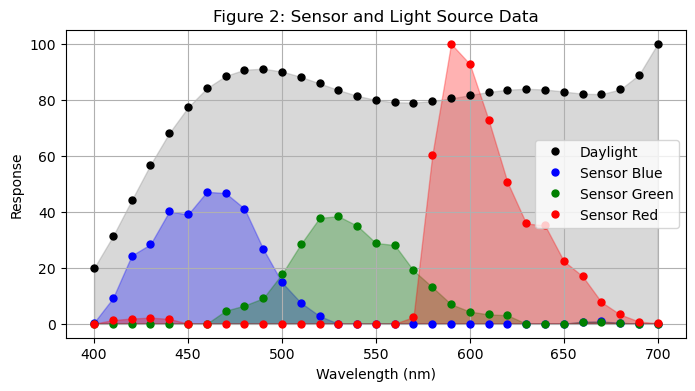

In [9]:
# Figure 2: Sensor response and light source spectrum (points and line)

plt.figure(figsize=(8, 4))

# Plot the Daylight spectrum (assumed to be stored in the 'Daylight' variable)
# 'o' markers are used for the data points, with black color.
plt.plot(Daylight[:,0], Daylight[:,1], 'o', markersize=5, color='black', label='Daylight')
# Fill the area under the Daylight curve with a light gray color
plt.fill_between(Daylight[:,0], Daylight[:,1], color='gray', alpha=0.3)

# Plot the Sensor Blue data using blue markers and line
plt.plot(SensorBlue[:,0], SensorBlue[:,1], 'o', markersize=5, color='blue', label='Sensor Blue')
# Fill the area under the Sensor Blue curve with a blue color
plt.fill_between(SensorBlue[:,0], SensorBlue[:,1], color='blue', alpha=0.3)

# Plot the Sensor Green data using green markers and line
plt.plot(SensorGreen[:,0], SensorGreen[:,1], 'o', markersize=5, color='green', label='Sensor Green')
# Fill the area under the Sensor Green curve with a green color
plt.fill_between(SensorGreen[:,0], SensorGreen[:,1], color='green', alpha=0.3)

# Plot the Sensor Red data using red markers and line
plt.plot(SensorRed[:,0], SensorRed[:,1], 'o', markersize=5, color='red', label='Sensor Red')
# Fill the area under the Sensor Red curve with a red color
plt.fill_between(SensorRed[:,0], SensorRed[:,1], color='red', alpha=0.3)

plt.title('Figure 2: Sensor and Light Source Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

#### 3. SensorTotal Fit: Chebyshev Polynomial of Degree 12

**Description:**  
Fit a Chebyshev polynomial of degree 12 to the SensorTotal data for stable and efficient function approximation.

**Inputs:**  
- **SensorTotal**: 2D array (wavelengths in column 1, sensor responses in column 2)
- **x_fit:** 300-point wavelength grid from 400 to 700 nm.

**Method:**  
- Extract wavelengths (`x_sensor`) and responses (`y_sensor`).
- Use `Chebyshev.fit` to compute the Chebyshev polynomial.
- Define `NSensorFit(x)` to evaluate the polynomial.

**Outputs:**  
- **cheb_fit**: Fitted Chebyshev polynomial (coefficients available via `cheb_fit.coef`)
- **NSensorFit(x)**: Function returning the polynomial value at a given wavelength.
- **NSensor_fit**: Resampled data, the evaluated polynomial values on the common grid.

In [10]:
# SensorTotal fit: 

# Extract wavelengths and corresponding sensor response values
x_sensor = SensorTotal[:, 0]
y_sensor = SensorTotal[:, 1]

# Fit a Chebyshev polynomial of degree 12 to the SensorTotal data.
# Chebyshev polynomials are used for their numerical stability and efficiency in approximating functions.
cheb_fit = Chebyshev.fit(x_sensor, y_sensor, 12)

def NSensorFit(x):
    return cheb_fit(x)

# Optional: Print the fitted Chebyshev coefficients for inspection
print("Chebyshev polynomial fit coefficients:", cheb_fit.coef)

NSensor_fit = NSensorFit(x_fit)
print("Fitted NSensor shape:", NSensor_fit.shape)

Chebyshev polynomial fit coefficients: [ 0.34510157 -0.11515904 -0.31924981  0.02426869 -0.04072533  0.09656001
  0.05035412 -0.05459439 -0.04298552  0.00747738  0.04597954  0.05036164
 -0.03743578]
Fitted NSensor shape: (300,)


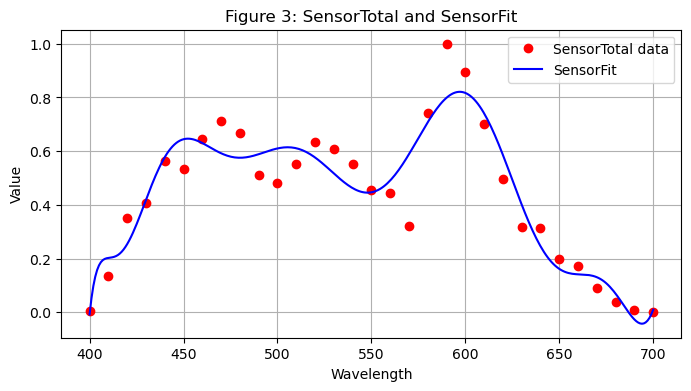

In [11]:
# Figure 3: Plot SensorTotal with SensorFit

plt.figure(figsize=(8, 4))
plt.plot(x_sensor, y_sensor, 'o', color='red', label='SensorTotal data')
plt.plot(x_fit, NSensor_fit, '-', color='blue', label='SensorFit')
plt.title('Figure 3: SensorTotal and SensorFit')
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### 2.2. Sensor Data Normalization with Daylight Intensity

**Description:**  
Normalize sensor responses (Blue, Green, Red) so that the integrated product with the daylight intensity equals 1. This is done by computing a normalization factor using the composite trapezoidal rule and scaling each sensor's response accordingly, based on equation:

$$
\int g_i(\lambda) \, d\lambda = 1 \quad \text{for } i = R, G, B
$$

**Inputs:**  
- **Daylight:** 2D array with wavelengths (column 1) and daylight intensity (column 2).  
- **SensorBlue, SensorGreen, SensorRed:** 2D arrays with wavelengths (column 1) and sensor responses (column 2).

**Method:**  
1. Extract wavelengths and daylight intensity from the Daylight array.  
2. Define a helper function `compute_norm(sensor)` that:
   - Multiplies sensor response by daylight intensity.
   - Computes the integral using `np.trapezoid`.
   - Calculates the normalization factor as the reciprocal of the integral (if nonzero).
3. Compute normalization factors for each sensor channel.
4. Scale each sensor's response by its respective normalization factor.
5. Optionally verify that the normalized responses integrate to ~1 when multiplied by the daylight intensity.
6. Plot the normalized sensor responses.

**Outputs:**  
- **SensorBlue_norm, SensorGreen_norm, SensorRed_norm:** Normalized sensor response arrays.  
- **Verification:** Printed integrals (expected to be close to 1) and a plot of the normalized responses.

In [12]:
# Extract wavelengths and daylight intensity
wavelengths = Daylight[:, 0]
daylight_intensity = Daylight[:, 1]

# Define a helper function to compute normalization factor for a given sensor channel
def compute_norm(sensor):
    sensor_response = sensor[:, 1]
    # Compute the integral using the composite trapezoidal rule
    integral = np.trapezoid(sensor_response * daylight_intensity, x=wavelengths)
    norm_factor = 1 / integral if integral != 0 else 0
    return norm_factor, integral

# Compute normalization factors for each sensor
norm_factor_blue, integral_blue = compute_norm(SensorBlue)
norm_factor_green, integral_green = compute_norm(SensorGreen)
norm_factor_red, integral_red = compute_norm(SensorRed)

# Apply normalization: each normalized sensor response satisfies
# ∫ [NormalizedSensor(λ) * DaylightIntensity(λ)] dλ = 1
SensorBlue_norm = SensorBlue.copy()
SensorGreen_norm = SensorGreen.copy()
SensorRed_norm = SensorRed.copy()

SensorBlue_norm[:, 1] *= norm_factor_blue
SensorGreen_norm[:, 1] *= norm_factor_green
SensorRed_norm[:, 1] *= norm_factor_red

# Optionally, verify the integrals are now ~1 using np.trapezoid
blue_integral_norm = np.trapezoid(SensorBlue_norm[:, 1] * daylight_intensity, x=wavelengths)
green_integral_norm = np.trapezoid(SensorGreen_norm[:, 1] * daylight_intensity, x=wavelengths)
red_integral_norm = np.trapezoid(SensorRed_norm[:, 1] * daylight_intensity, x=wavelengths)

print("Normalized Blue sensor integral:", blue_integral_norm)
print("Normalized Green sensor integral:", green_integral_norm)
print("Normalized Red sensor integral:", red_integral_norm)

Normalized Blue sensor integral: 1.0
Normalized Green sensor integral: 1.0000000000000002
Normalized Red sensor integral: 1.0000000000000004


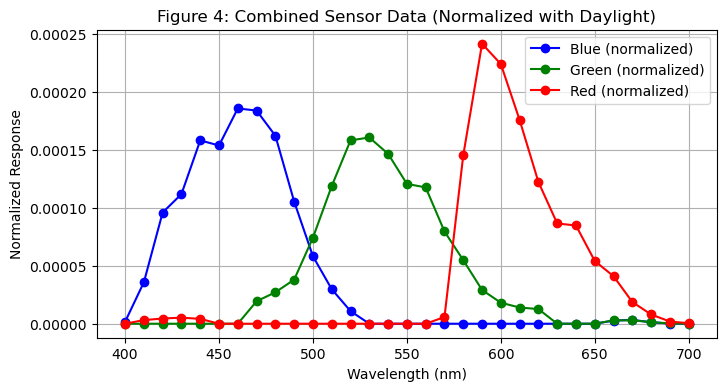

In [13]:
# Figure 4: Final Combined Sensor Plot (overlaid) with Normalization

plt.figure(figsize=(8, 4))

plt.plot(wavelengths, SensorBlue_norm[:, 1], 'o-', color='blue', label='Blue (normalized)')
plt.plot(wavelengths, SensorGreen_norm[:, 1], 'o-', color='green', label='Green (normalized)')
plt.plot(wavelengths, SensorRed_norm[:, 1], 'o-', color='red', label='Red (normalized)')

plt.title('Figure 4: Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

## 3. CHL Curve Modification and Visualization

### 3.1. Modified CHL Curve with Shift and Tilt

**Description:**  
This code modifies the CHL curve by applying a horizontal shift (`x_shift`) and adjusting its slope by tilting the derivative with factors `tilt_left` and `tilt_right`. The transformation preserves the curve's monotonicity by scaling the derivative differently on either side of a pivot. The base CHL curve is obtained from a polynomial fit (via `CHLFit`) over the wavelength range 400–700 nm stored in `x_fit`.

**Input:**  
- **`x_fit`**: A NumPy array of wavelength values from 400 to 700 nm (e.g., generated with `np.linspace(400, 700, 300)`).
- **`CHL_fit`**: The corresponding CHL values computed from the polynomial fit using `CHLFit(x_fit)`.
- **`x_shift`**: A horizontal shift applied to the curve.
- **`tilt_left`**: A scaling factor applied to the derivative for wavelengths less than the pivot.
- **`tilt_right`**: A scaling factor applied to the derivative for wavelengths greater than or equal to the pivot.

**Method:**  
- **Determine the Pivot:**  
  - Compute the original lowest point (`x_min`, `y_min`) from the fitted CHL curve using `x_fit` and the corresponding values from `CHL_fit`.
  - Define the pivot as `pivot_x = x_min + x_shift` and set `pivot_y = CHLFit(x_min)`.
  
- **Compute the Modified Curve:**  
  - Shift the base CHL curve horizontally by evaluating `CHLFit` at `x_fit - x_shift`.
  - Calculate the numerical derivative of the shifted curve using `np.gradient`.
  - Apply scaling by multiplying the derivative by `(1 + tilt_left)` for wavelengths less than `pivot_x` and by `(1 + tilt_right)` for wavelengths greater than or equal to `pivot_x`.
  - Integrate the modified derivative (both forward and backward from the pivot) to reconstruct the modified CHL curve.
  
- **Interactive Interface:**  
  - Interactive sliders for `x_shift`, `tilt_left`, and `tilt_right` enable real-time adjustments.
  - The updated curve is plotted, and sampled values (every 10 nm) are extracted and displayed as a 2-column array.

**Outputs:**  
- **`global_modified_curve`**: A continuous curve over 400–700 nm with an adjusted slope while preserving the overall monotonic behavior.  
- **`global_CHLfit`**: A 2-column matrix where the first column represents the wavelength and the second column contains the integer part (using `np.floor`) of the corresponding modified CHL value.

In [14]:
# Define the wavelength range for plotting.
dx = x_fit[1] - x_fit[0]

# Compute the original lowest point on 400–700 nm using x_fit and CHL_fit.
x_min = x_fit[np.argmin(CHL_fit)]
y_min = np.min(CHL_fit)
print("Original lowest point at x = {:.2f} nm, y = {:.2f}".format(x_min, y_min))

def CHLFit_mod(x_vals, x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Returns the modified CHL curve with preserved monotonicity by scaling the derivative.
    
    Procedure:
      1. Define the pivot: pivot_x = x_min + x_shift, with pivot_y = CHLFit(x_min).
      2. Evaluate the base curve at shifted x-values: f(x) = CHLFit(x - x_shift).
      3. Compute its numerical derivative.
      4. Multiply the derivative by (1 + tilt_left) for x < pivot_x and (1 + tilt_right) for x >= pivot_x.
      5. Integrate the new derivative (with g(pivot)=pivot_y) to construct the modified curve.
      
    This ensures that if (1 + tilt) > 0 on both sides, the sign of the derivative remains unchanged.
    """
    pivot_x = x_min + x_shift
    pivot_y = CHLFit(x_min)
    
    # Compute the horizontally shifted base curve.
    x_shifted = x_vals - x_shift
    base = CHLFit(x_shifted)
    
    # Compute numerical derivative.
    dbase = np.gradient(base, dx)
    
    # Scale the derivative based on the pivot.
    factor = np.where(x_vals < pivot_x, 1 + tilt_left, 1 + tilt_right)
    new_deriv = dbase * factor
    
    # Integrate the new derivative.
    g = np.empty_like(x_vals)
    pivot_index = np.argmin(np.abs(x_vals - pivot_x))
    g[pivot_index] = pivot_y
    
    # Integrate forward from the pivot.
    for i in range(pivot_index + 1, len(x_vals)):
        g[i] = g[i - 1] + new_deriv[i - 1] * dx
    # Integrate backward from the pivot.
    for i in range(pivot_index - 1, -1, -1):
        g[i] = g[i + 1] - new_deriv[i + 1] * dx
        
    return g

def plot_CHL(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Plots the modified CHL curve, applying a multiplicative tilt to the derivative.
    
    The parameters tilt_left and tilt_right (both > -1) adjust the slopes on the left and right,
    and x_shift shifts the base curve horizontally.
    """
    y_vals = CHLFit_mod(x_fit, x_shift, tilt_left, tilt_right)
    
    plt.figure(figsize=(8, 4))
    plt.plot(x_fit, y_vals, label='Modified CHL Curve', lw=2)
    plt.scatter(x_CHL, y_CHL, color='red', label='Data Points')
    plt.scatter([x_min], [y_min], color='green', s=100, label='Original Lowest Point')
    plt.scatter([x_min + x_shift], [CHLFit(x_min)], color='blue', s=100, label='Shifted Pivot')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('CHL Value')
    plt.title('CHL Curve with x-axis Shift and Tilt Preserving Monotonicity')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.show()

def extract_modified_curve_values(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Extracts the y-values of the modified CHL curve at x_fit (400–700 nm),
    returning only their integer parts using np.floor.
    """
    y_modified = CHLFit_mod(x_fit, x_shift, tilt_left, tilt_right)
    y_modified_int = np.floor(y_modified)
    return y_modified_int

def extract_sampled_modified_values(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Extracts the modified CHL curve sampled every 10 nm (from 400 to 700 nm)
    and returns a 2-column matrix: first column for wavelength, second for the integer CHL value.
    """
    x_sample = np.arange(400, 701, 10)
    y_sample = CHLFit_mod(x_sample, x_shift, tilt_left, tilt_right)
    y_sample_int = np.floor(y_sample)
    return np.column_stack((x_sample, y_sample_int))

# Global variables to store results after interactive updates.
global_modified_curve = None
global_CHLfit = None

# Define interactive sliders.
x_shift_slider = FloatSlider(min=-50, max=50, step=1, value=0, description='x Shift (nm)')
tilt_left_slider = FloatSlider(min=-0.9, max=1.0, step=0.01, value=0, description='Tilt Left')
tilt_right_slider = FloatSlider(min=-0.9, max=1.0, step=0.01, value=0, description='Tilt Right')

# Output area for updating display.
out = Output()

def update_all(x_shift, tilt_left, tilt_right):
    global global_modified_curve, global_CHLfit
    with out:
        out.clear_output(wait=True)
        # Plot the modified curve.
        plot_CHL(x_shift, tilt_left, tilt_right)
        # Save the sampled data.
        global_CHLfit = extract_sampled_modified_values(x_shift, tilt_left, tilt_right)
        # Save the full modified curve.
        global_modified_curve = CHLFit_mod(x_fit, x_shift, tilt_left, tilt_right)
        print("Modified CHLzf85 = np.array(")
        print(global_CHLfit.tolist())
        print(")")
        print("global_modified_curve shape:", global_modified_curve.shape)
        
# Create the interactive interface.
interact(update_all, 
         x_shift=x_shift_slider, 
         tilt_left=tilt_left_slider, 
         tilt_right=tilt_right_slider)

display(out)

Original lowest point at x = 501.34 nm, y = -63.42


interactive(children=(FloatSlider(value=0.0, description='x Shift (nm)', max=50.0, min=-50.0, step=1.0), Float…

Output()

### 3.2. Combination with Weighting Spectrum and Visualization

#### 1. Custom Wavelength Colormap and Density Plot

**Description:**  
Generate a custom colormap that represents wavelengths from 400 nm to 700 nm, then use it to create a density plot where the color indicates the wavelength.

**Method:**  
- Generate an array of wavelengths (400–700 nm) and convert each to an RGB value using `wavelength_to_rgb`.  
- Create a linear segmented colormap from these colors.  
- Construct a meshgrid over the wavelength range (x-axis) and a y-range (0 to 50).  
- Plot a pseudocolor plot with `pcolormesh` where the function value equals the wavelength, applying the custom colormap.

**Outputs:**  
- A density plot displaying the real colors corresponding to wavelengths.  
- A colorbar labeled in nanometers.

In [15]:
# Function converts a wavelength (in nanometers) from the visible spectrum into an approximate RGB color value.

def wavelength_to_rgb(wavelength, gamma=0.8):
    """
    Convert a given wavelength in nm to an RGB color.
    Based on the algorithm from Dan Bruton:
    http://www.efg2.com/Lab/ScienceAndEngineering/Spectra.htm
    """
    if 380 <= wavelength < 440:
        attenuation = 0.3 + 0.7*(wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength < 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0 ** gamma
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0 ** gamma
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength < 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0 ** gamma
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0 ** gamma
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 780:
        attenuation = 0.3 + 0.7*(780 - wavelength) / (780 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = G = B = 0.0

    return (R, G, B)

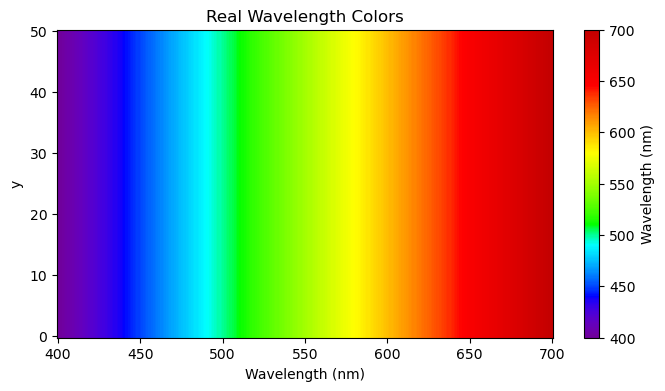

In [16]:
# Create a custom colormap from wavelengths 400 nm to 700 nm.
colormap_wavelengths = np.linspace(400, 700, 300)
colors = [wavelength_to_rgb(w) for w in colormap_wavelengths]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# --- Plot 1: DensityPlot Equivalent ---
# Create the grid and function values.
x_vals = np.linspace(400, 700, 300)
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X  # f(x,y) = x

plt.figure(figsize=(8, 4))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=custom_cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

#### 2. Dual-Axis Plot with Expanded y-Axis Range and Shared y=0

**Description:**  
This code creates a dual-axis plot where the global CHLfit data and the sensor data (Blue, Green, and Red) are displayed on separate y-axes. The y-axis limits are expanded with margins, and the sensor axis is adjusted so that zero lies at the same relative position as on the global axis.

**Method:**  
1. **Define Global Limits:**  
   - Set initial global limits (`global_min = -80`, `global_max = 250`), compute a 10% margin, and adjust the limits.
   - Calculate the relative position `r` where zero lies on the global axis with margin.

2. **Adjust Sensor Limits:**  
   - Find the maximum sensor value among the normalized sensor datasets.
   - Add a 10% margin to this maximum.
   - Compute the sensor lower limit (`sensor_min_new`) so that 0 is at the same relative position as in the global axis.

3. **Create Dual-Axis Plot:**  
   - Generate a figure with two y-axes using `plt.subplots()` and `twinx()`.
   - Set the y-axis limits for both axes using the computed values.

4. **Plot Data:**  
   - **Global CHLfit Data:** Plot the data as a gradient line (using a custom colormap) with markers on the primary y-axis.
   - **Sensor Data:** For each sensor (Blue, Green, Red), plot the data as gradient line segments and markers on the secondary y-axis.
   - Draw horizontal lines at y = 0 on both axes for clarity.

5. **Finalize the Plot:**  
   - Label axes, add a combined legend, and display the plot.

**Inputs:**  
- **global_CHLfit:** 2D array with wavelengths and CHLfit values.
- **SensorBlue_norm, SensorGreen_norm, SensorRed_norm:** 2D arrays with wavelengths and normalized sensor responses.
- **custom_cmap:** A colormap created from wavelengths (400–700 nm).
- **Global axis limits:** `global_min = -80`, `global_max = 250`.

**Outputs:**  
- A dual-axis plot displaying the global CHLfit data and the sensor data with properly adjusted y-axis ranges and a shared zero line.

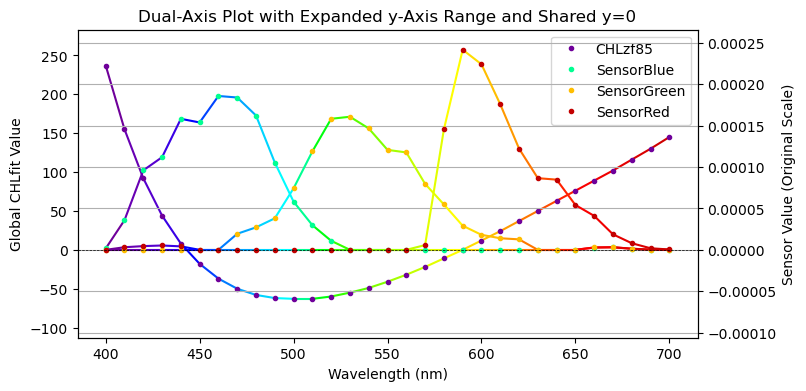

In [17]:
# Original global axis limits:
global_min, global_max = -80, 250
global_range = global_max - global_min
margin_global = 0.1 * global_range  # 10% margin

# Adjusted global limits with margin:
new_global_min = global_min - margin_global
new_global_max = global_max + margin_global

# Compute the fraction where zero lies on the global axis (with margin):
r = (0 - new_global_min) / (new_global_max - new_global_min)

# For sensor data, determine the maximum sensor value (across all sensor datasets).
sensor_max = max(SensorBlue_norm[:, 1].max(), SensorGreen_norm[:, 1].max(), SensorRed_norm[:, 1].max())
# Add a margin to the sensor_max (10% of sensor_max)
sensor_margin = 0.1 * sensor_max
sensor_max_new = sensor_max + sensor_margin

# Compute the sensor lower limit such that 0 lies at the same relative position.
sensor_min_new = - (r / (1 - r)) * sensor_max_new

# Prepare the figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

# Set the y-axis limits:
ax1.set_ylim(new_global_min, new_global_max)
ax2.set_ylim(sensor_min_new, sensor_max_new)

# Plot the global_CHLfit data on the primary axis (ax1).
x_vals = global_CHLfit[:, 0]
y_vals = global_CHLfit[:, 1]
norm = plt.Normalize(400, 700)
colors_mapped = custom_cmap(norm(x_vals))
# Draw the gradient line segments:
for j in range(len(x_vals) - 1):
    ax1.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
# Plot uniform markers:
marker_color = custom_cmap(0 / 3)  # Using index 0 for global_CHLfit
ax1.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label='CHLzf85')

# Plot the sensor datasets on the secondary axis (ax2).
sensor_datasets = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_labels = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, label) in enumerate(zip(sensor_datasets, sensor_labels), start=1):
    x_vals = sensor[:, 0]
    y_vals = sensor[:, 1]
    norm = plt.Normalize(400, 700)
    colors_mapped = custom_cmap(norm(x_vals))
    for j in range(len(x_vals) - 1):
        ax2.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
    marker_color = custom_cmap(i / 3)  # Spread markers uniformly over the colormap
    ax2.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label=label)

# Add horizontal lines at y=0 on both axes for clarity.
ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Set axis labels.
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Global CHLfit Value')
ax2.set_ylabel('Sensor Value (Original Scale)')

# Combine legends from both axes and position in upper right.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Dual-Axis Plot with Expanded y-Axis Range and Shared y=0')
plt.grid(True)
plt.show()

#### 3. Defocus Plots: Modified CHL Curve and SensorFit Multiplication

**Description:**  
This section plots the effect of a defocus parameter \( z \) on the modified CHL curve and its interaction with the sensor response. Two plots are generated:
1. The absolute scaled difference between \( z \) and the modified CHL curve.
2. The product of the above difference with the SensorFit curve.

**Method:**  
- **Compute \( y_1 \):**  

  $$
  y_1 = \left|\frac{z - \text{global\_modified\_curve}}{\sqrt{4K^2 - 1}}\right|
  $$

  This value is computed over wavelengths from 400 to 700 nm. This residue acts as an indicator of which wavelengths are exactly at focus (where the expression equals zero) and which are not, effectively mapping the chromatic defocus across the spectrum.

- **Compute \( y_2 \):**  

  $$
  y_2 = y_1 \times \text{NSensorFit}(x)
  $$

  This shows the effect when the defocus term is modulated by the sensor response.

- Use an interactive slider to adjust \( z \) within the defocus range, updating the plots in real time.

**Inputs:**  
- **global\_modified\_curve:** Modified CHL curve obtained from previous interactive adjustments.  
- **\( x \) (x\_vals):** Wavelength array spanning 400 to 700 nm.  
- **NSensorFit:** Function providing sensor fit values.  
- **Parameters:** \( \text{defocusrange} \), \( K \), \( A \).

**Outputs:**  
- Two side-by-side plots displaying:
  - The computed \( y_1 \) values (absolute scaled difference).
  - The computed \( y_2 \) values (modulated by SensorFit).

In [18]:
# Define parameters
defocusrange = 400
K = 1.4
A = 100
denom = np.sqrt(4*K**2 - 1)
x_vals = np.linspace(400, 700, 300)
def update_plots(z):
    """
    Plots two figures:
      1. Plot of | (z - Modified CHL Curve) / sqrt(4*K^2-1) |.
      2. Plot of the above result multiplied by the curve from SensorFit.
      
    This function uses the global variable 'global_modified_curve' generated from the CHL interactive part.
    
    Parameters:
        z: The defocus parameter (a scalar) that shifts the curve vertically.
    """
    # Check if the global modified curve has been generated
    if global_modified_curve is None:
        print("Please adjust the CHL curve using the slider above first.")
        return

    # Create a subplot with 2 figures side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # First plot: Compute the absolute value of (z - Modified CHL Curve) / denom
    y1 = np.abs((z - global_modified_curve) / denom)
    axs[0].plot(x_vals, y1, '-', color='purple')
    axs[0].fill_between(x_vals, y1, color='purple', alpha=0.3)
    axs[0].set_title(f'| (z - Modified CHL)/sqrt(4*K^2-1) |, z = {z}')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Value')
    axs[0].set_ylim(0, A)
    axs[0].grid(True)
    
    # Second plot: Multiply the first result by SensorFit evaluated at x_vals
    sensor_fit_vals = NSensorFit(x_vals)
    y2 = y1 * sensor_fit_vals
    axs[1].plot(x_vals, y2, '-', color='orange')
    axs[1].fill_between(x_vals, y2, color='orange', alpha=0.3)
    axs[1].set_title('Multiplied by SensorFit')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Value')
    axs[1].set_ylim(0, 100)
    axs[1].grid(True)
    
    plt.show()

# Create an interactive slider to adjust the defocus parameter 'z'
interact(update_plots, 
         z=widgets.FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description='defocus'))

# Print shapes for debugging/verification purposes
print("x_vals shape:", x_vals.shape)
print("global_modified_curve shape:", global_modified_curve.shape)
sensor_fit_vals = NSensorFit(x_vals)
print("SensorFit(x_vals) shape:", sensor_fit_vals.shape)

interactive(children=(FloatSlider(value=0.0, description='defocus', max=400.0, min=-400.0, step=1.0), Output()…

x_vals shape: (300,)
global_modified_curve shape: (300,)
SensorFit(x_vals) shape: (300,)


## 4. Overexposure and Color Fringe Focus Calculation

### 4.1 Data and Exposure Function Definition

**CHL Data:**
- **CHLdata:** Active CHL data extracted as the second column of `global_CHLfit`.

**Sensor Data:**
- **SensorBluedata:** Second column of `SensorBlue_norm`.
- **SensorGreendata:** Second column of `SensorGreen_norm`.
- **SensorReddata:** Second column of `SensorRed_norm`.

**Global Constant:**
- \( K = 1.4 \)

**Exposure Function:**

The exposure function is defined as:

$$
\text{Exposure}(x, F) = \frac{\tanh(F \cdot x)}{\tanh(F)}
$$

This function normalizes the hyperbolic tangent of $ F \cdot x $ by dividing by $\tanh(F)$, ensuring the output is scaled consistently.

In [19]:
# CHLdata (active definition)
CHLdata = global_CHLfit[:, 1]

SensorBluedata = SensorBlue_norm[:, 1]
SensorGreendata = SensorGreen_norm[:, 1]
SensorReddata = SensorRed_norm[:, 1]

# Global constant
K = 1.4
# ---------------------------
# Exposure Function
# (Mathematica: Exposure[x_, F_] := Tanh[F*x]/Tanh[F])
# ---------------------------
def Exposure(x, F):
    return np.tanh(F * x) / np.tanh(F)

### 4.2 Color Fringe Calculation

#### 1. Weighting Functions Comparison

**Description:**  
This code defines and compares two weighting functions:
- **Ideal Weight:** A step function with linear interpolation that transitions from 0 to 1 over a specified interval.
- **Gaussian Weight:** A smooth, Gaussian-like step function using the error function for a gradual transition.

**Method:**  
- **`ideal_weight(x, ratio)`:**  
  - For a very small `ratio`, it behaves as a hard step: returns 1 if \( x \ge 0 \) and 0 otherwise.
  - For \( x \ge \text{ratio} \), it returns 1; for \( x \le -\text{ratio} \), it returns 0.
  - For values in between, it linearly interpolates as:  
    \[
    0.5 \left( 1 + \frac{x}{\text{ratio}} \right)
    \]

- **`gaussian_weight(x, ratio)`:**  
  - For a very small `ratio`, it also behaves as a hard step.
  - Otherwise, it computes a smooth transition using the error function:
    \[
    0.5\left(1 + \mathrm{erf}\left(\frac{x}{\sqrt{2}\, \text{ratio}}\right)\right)
    \]

**Testing and Plotting:**  
- An array of \( x \) values is generated from -100 to 100.
- The ideal and Gaussian weights are computed for these values with a given `ratio` (e.g., 20).
- A hard ideal step function (0 for \( x < 0 \), 1 for \( x \ge 0 \)) is also defined.
- All three functions are plotted for visual comparison.

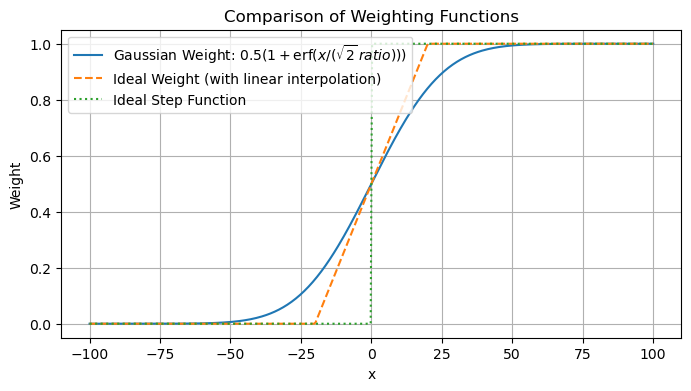

In [20]:
# Define two weighting functions
def ideal_weight(x, ratio):
    """Ideal step function with linear interpolation."""
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    if x >= ratio:
        return 1
    elif x <= -ratio:
        return 0
    else:
        return 0.5 * (1 + x/ratio)

def gaussian_weight(x, ratio):
    """Smooth Gaussian-like step using the error function."""
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    return 0.5 * (1 + erf(x / (np.sqrt(2) * ratio)))

# Define a range of x values and a ratio parameter
x = np.linspace(-100, 100, 400)
ratio = 20  # adjust as needed

# Compute weights using the two functions
y_ideal = np.array([ideal_weight(val, ratio) for val in x])
y_gaussian = np.array([gaussian_weight(val, ratio) for val in x])

# Define the hard ideal step function
y_step = np.where(x < 0, 0, 1)

# Plot all three functions
plt.figure(figsize=(8, 4))
plt.plot(x, y_gaussian, label=r'Gaussian Weight: $0.5(1+\mathrm{erf}(x/(\sqrt{2}\,ratio)))$')
plt.plot(x, y_ideal, label='Ideal Weight (with linear interpolation)', linestyle='--')
plt.plot(x, y_step, label='Ideal Step Function', linestyle=':')
plt.xlabel("x")
plt.ylabel("Weight")
plt.title("Comparison of Weighting Functions")
plt.legend()
plt.grid(True)
plt.show()


#### 2. Defocus Edge and Spot Diagram Analysis

**Description:**  
This code computes and visualizes edge responses and color fringes based on a modified CHL curve and sensor data. It uses interactive controls to adjust defocus, exposure, and gamma parameters, allowing analysis of how these changes affect the edge functions and the resulting spot diagram.

**Method:**  
1. **Global Parameters:**  
   - **K:** Constant value (1.4).  
   - **xrange_val:** Range for x values in the plots (200).  
   - **defocusrange:** Maximum defocus shift (1000).  
   - **tol:** Tolerance for detecting significant color differences (0.15).

2. **Data Definitions:**  
   - **CHLdata:** Active CHL values extracted from `global_CHLfit`.  
   - **SensorReddata, SensorGreendata, SensorBluedata:** Sensor responses from normalized sensor data arrays.

3. **Edge Computation:**  
   - **compute_edge:**  
     Computes an edge response for a given sensor channel by:
     - Calculating a weighted sum of sensor data, where the weight is a function of the normalized distance
       $$
       \text{ratio} = \left|\frac{z - \text{CHLdata}[n]}{\sqrt{4K^2 - 1}}\right|
       $$
     - The weight is determined by a chosen weighting function (either an ideal step with interpolation or a Gaussian-like smooth function).
     - The result is normalized by the sum of sensor data and passed through the `Exposure` function raised to an exponent \( g \).

   - **EdgeR, EdgeG, EdgeB:**  
     Compute the edge responses for the red, green, and blue channels respectively.

5. **Color Fringe and Edge Width:**  
   - **Farbsaum:**  
     Compares the edge responses from the three channels. If the difference between any pair exceeds the tolerance \( tol \), it returns 1; otherwise, 0.
   - **Farbsaumbreite:**  
     Sums the `Farbsaum` values over a specified x-range to provide an overall measure of the edge width.
   - **ColorFringe:**  
     Returns an RGB tuple by combining the edge responses from the three sensor channels.

6. **Interactive Plotting:**  
   - **update_plots(z, F, gamma, model):**  
     - **Weighting Function Selection:**  
       Chooses either the ideal or Gaussian weighting function based on the selected model.
     - **Figure Layout:**  
       Creates a multi-panel figure:
       - **Top Left:** Plots the edge spread functions (EdgeR, EdgeG, EdgeB) along with the `Farbsaum` curve.
       - **Top Right:** Displays a density plot where the color at each x-value is given by the `ColorFringe` function, replicated vertically.
       - **Bottom:** Generates a 2D spot diagram where each point’s color is computed from the radial distance using `ColorFringe`.
     - **Output:**  
       The overall edge width computed by `Farbsaumbreite` is printed for verification.

7. **Interactive Controls:**  
   - **defocus (z):** Adjusts the vertical shift applied to the CHL curve.
   - **Exposure F (F):** Controls the steepness of the Exposure function.
   - **Gamma (gamma):** Exponent used in the Exposure function.
   - **Model:** Chooses between 'Ideal Weight' and 'Gaussian Weight' for the weighting function.

**Outputs:**  
- Three interactive plots:
  - Edge spread functions (with overlaid color discontinuity indicator).
  - A density plot showing the computed ColorFringe.
  - A 2D spot diagram visualizing color fringes across the sensor.
- The computed overall edge width is printed to the console.

In [21]:
# original + gaussian + width(maximum)

xrange_val = 200    # Range for x values in plots
defocusrange = 1000
tol = 0.15

# Create a generic edge function that works for any sensor channel and weighting
def compute_edge(x, z, F, g, sensor_data, weight_func):
    denom_factor = np.sqrt(4 * K**2 - 1)
    num = 0
    for n in range(len(CHLdata)):
        ratio = abs((z - CHLdata[n]) / denom_factor)
        weight = weight_func(x, ratio)
        num += sensor_data[n] * weight
    den = np.sum(sensor_data)
    return Exposure(num/den, F) ** g

# Define edge functions for each color channel
def EdgeR(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorReddata, weight_func)

def EdgeG(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorGreendata, weight_func)

def EdgeB(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorBluedata, weight_func)

# Farbsaum (binary method) remains unchanged
def Farbsaum(x, z, F, g, weight_func):
    r = EdgeR(x, z, F, g, weight_func)
    g_val = EdgeG(x, z, F, g, weight_func)
    b = EdgeB(x, z, F, g, weight_func)
    if abs(r - b) > tol or abs(r - g_val) > tol or abs(g_val - b) > tol:
        return 1
    return 0

def Farbsaumbreite(z, F, g, weight_func):
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val)) + 1)
    return np.sum([Farbsaum(x, z, F, g, weight_func) for x in xs])

# New functions for maximum method
def color_diff(x, z, F, g, weight_func):
    r = EdgeR(x, z, F, g, weight_func)
    g_val = EdgeG(x, z, F, g, weight_func)
    b = EdgeB(x, z, F, g, weight_func)
    # Return the maximum absolute difference between any two channels.
    return max(abs(r - g_val), abs(r - b), abs(g_val - b))

def Farbsaumbreite_max(z, F, g, weight_func):
    # Fine sampling along x for a continuous profile.
    xs = np.linspace(-xrange_val, xrange_val, 1000)
    diff_profile = np.array([color_diff(x, z, F, g, weight_func) for x in xs])
    max_diff = np.max(diff_profile)
    # Define half maximum threshold.
    threshold = 0.5 * max_diff
    # Identify x values where the difference is above threshold.
    valid_xs = xs[diff_profile >= threshold]
    if len(valid_xs) > 0:
        width = valid_xs[-1] - valid_xs[0]
    else:
        width = 0
    return width

# ColorFringe function returns an RGB tuple
def ColorFringe(x, z, F, g, weight_func):
    return (EdgeR(x, z, F, g, weight_func),
            EdgeG(x, z, F, g, weight_func),
            EdgeB(x, z, F, g, weight_func))

def update_plots(z, F, gamma, model, width_method):
    # Select weighting function based on chosen model.
    weight_func = ideal_weight if model == 'Ideal Weight' else gaussian_weight

    # Create a figure with a GridSpec: top row with two columns for the original plots,
    # and a bottom row spanning both columns for the spot diagram.
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Top left: Edge spread functions
    ax1 = fig.add_subplot(gs[0, 0])
    xs = np.linspace(-xrange_val, xrange_val, 400)
    edgeR_vals = np.array([EdgeR(x, z, F, gamma, weight_func) for x in xs])
    edgeG_vals = np.array([EdgeG(x, z, F, gamma, weight_func) for x in xs])
    edgeB_vals = np.array([EdgeB(x, z, F, gamma, weight_func) for x in xs])
    farb_vals = np.array([Farbsaum(x, z, F, gamma, weight_func) for x in xs])
    
    ax1.plot(xs, edgeR_vals, color=(1, 0, 0), label='EdgeR')
    ax1.plot(xs, edgeG_vals, color=(0, 1, 0), label='EdgeG')
    ax1.plot(xs, edgeB_vals, color=(0, 0, 1), label='EdgeB')
    ax1.plot(xs, farb_vals, color=(0.2, 0.2, 0.2), label='Farbsaum')
    ax1.set_title(f"Edge functions ({model} weighting)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Response")
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True)
    
    # Top right: Density plot using ColorFringe (1D slice replicated vertically)
    ax2 = fig.add_subplot(gs[0, 1])
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, weight_func)
    img = np.clip(img, 0, 1)
    ax2.imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val], aspect='auto')
    ax2.set_title("Density plot (ColorFringe)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    
    # Bottom: Spot diagram (2D)
    ax3 = fig.add_subplot(gs[1, :])
    grid_size = 100
    spot_range = np.linspace(-xrange_val/2, xrange_val/2, grid_size)
    X_spot, Y_spot = np.meshgrid(spot_range, spot_range)
    R_spot = np.sqrt(X_spot**2 + Y_spot**2)
    
    spot_img = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            spot_img[i, j, :] = ColorFringe(R_spot[i, j], z, F, gamma, weight_func)
    spot_img = np.clip(spot_img, 0, 1)
    ax3.imshow(spot_img, extent=[-xrange_val/2, xrange_val/2, -xrange_val/2, xrange_val/2])
    ax3.set_title("Spot Diagram")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    
    plt.tight_layout()
    plt.show()
    
    # Compute the color width using the selected method.
    if width_method == 'Original':
        width = Farbsaumbreite(z, F, gamma, weight_func)
    else:  # 'Maximum'
        width = Farbsaumbreite_max(z, F, gamma, weight_func)
    
    print(f"Color width ({width_method} method) =", width)

# Create the interactive widget with an added width_method parameter.
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="defocus"),
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=4, step=0.1, value=1, description="Gamma"),
         model=RadioButtons(options=['Ideal Weight', 'Gaussian Weight'], description='Model'),
         width_method=RadioButtons(options=['Binary', 'Maximum'], description='Width Method'));


interactive(children=(FloatSlider(value=0.0, description='defocus', max=1000.0, min=-1000.0, step=1.0), FloatS…

### Edge and Spot Diagram with Spherical Aberration Correction

**Description:**  
This code computes edge responses and generates color fringe (spot) diagrams for sensor channels (R, G, B) while incorporating a spherical aberration (SA) offset. Interactive controls allow you to adjust the defocus parameter \( z \), exposure parameter \( F \), gamma (\( \gamma \)), and SA offset, as well as select the weighting function model.

**Method:**  
1. **Effective Defocus with SA:**  
   The effective defocus is computed by adding a spherical aberration offset that scales with the square of \( x \):
   $$
   z_{\text{eff}} = z + 40 \cdot SA \cdot \frac{x^2}{\text{xrange\_val}^2}
   $$
   
2. **Edge Response Calculation:**  
   For each sensor channel, the edge function is determined by:
   - Looping over the CHL data points.
   - Computing a normalized distance (ratio) for each point:
     $$
     \text{ratio} = \left|\frac{z_{\text{eff}} - \text{CHLdata}[n]}{\sqrt{4K^2 - 1}}\right|
     $$
   - Applying a weighting function (either an ideal step with interpolation or a Gaussian-like smooth function) to compute the contribution.
   - Aggregating the weighted sensor data, normalizing by the total sensor data sum, and passing the result through an exposure function:
     $$
     \text{Exposure}(x, F) = \frac{\tanh(F \cdot x)}{\tanh(F)}
     $$
     raised to the power \( \gamma \).

3. **Edge Functions for Color Channels:**  
   Separate functions \( \text{EdgeR} \), \( \text{EdgeG} \), and \( \text{EdgeB} \) compute the edge responses for red, green, and blue sensor channels respectively using the generic edge function.

4. **Color Fringe and Edge Width:**  
   - **ColorFringe:** Returns an RGB tuple \((\text{EdgeR}, \text{EdgeG}, \text{EdgeB})\) for a given \( x \).
   - **Farbsaum:** Compares the edge responses; if the differences exceed a set tolerance (\( tol \)), it flags a discontinuity.
   - **Farbsaumbreite:** Computes an overall edge width by summing the flagged discontinuities over a range of \( x \).

5. **Interactive Plotting:**  
   The `update_plots` function creates a multi-panel figure:
   - **Top Left:** Plots the edge functions for each channel and the discontinuity indicator.
   - **Top Right:** Shows a density plot of the ColorFringe function (a 1D slice replicated vertically).
   - **Bottom:** Generates a 2D spot diagram using radial distances as input to ColorFringe.
   - The overall edge width is printed for verification.

6. **Interactive Controls:**  
   Sliders allow real-time adjustment of:
   - **\( z \):** Defocus parameter.
   - **\( F \):** Exposure parameter.
   - **\( \gamma \):** Gamma exponent.
   - **\( SA \):** Spherical aberration offset.
   - **Model:** Selection between "Ideal Weight" and "Gaussian Weight" for the weighting function.

**Outputs:**  
- **Plots:**  
  - Edge spread functions for each color channel and the combined discontinuity indicator.
  - A density plot illustrating the color fringe (ColorFringe) response.
  - A 2D spot diagram representing the overall color fringe effect.
- **Edge Width:**  
  The computed overall edge width is printed to the console.

In [22]:
# original + gaussian + spherical aberration

# Create a generic edge function that works for any sensor channel and weighting.
# Now including a spherical aberration offset SA.
def compute_edge(x, z, F, g, sensor_data, weight_func, SA=0):
    denom_factor = np.sqrt(4 * K**2 - 1)
    # Compute the effective defocus by adding a spherical aberration offset.
    # The offset increases with the square of x (normalized by xrange_val).
    z_eff = z + 40*SA * (x**2) / (xrange_val**2)
    
    num = 0
    for n in range(len(CHLdata)):
        ratio = abs((z_eff - CHLdata[n]) / denom_factor)
        weight = weight_func(x, ratio)
        num += sensor_data[n] * weight
    den = np.sum(sensor_data)
    return Exposure(num/den, F) ** g

# Define edge functions for each color channel
def EdgeR(x, z, F, g, weight_func, SA=0):
    return compute_edge(x, z, F, g, SensorReddata, weight_func, SA)

def EdgeG(x, z, F, g, weight_func, SA=0):
    return compute_edge(x, z, F, g, SensorGreendata, weight_func, SA)

def EdgeB(x, z, F, g, weight_func, SA=0):
    return compute_edge(x, z, F, g, SensorBluedata, weight_func, SA)

# Farbsaum and Farbsaumbreite functions remain similar,
# now propagating the SA parameter.
def Farbsaum(x, z, F, g, weight_func, SA=0):
    r = EdgeR(x, z, F, g, weight_func, SA)
    g_val = EdgeG(x, z, F, g, weight_func, SA)
    b = EdgeB(x, z, F, g, weight_func, SA)
    if abs(r - b) > tol or abs(r - g_val) > tol or abs(g_val - b) > tol:
        return 1
    return 0

def Farbsaumbreite(z, F, g, weight_func, SA=0):
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val))+1)
    return np.sum([Farbsaum(x, z, F, g, weight_func, SA) for x in xs])

# ColorFringe function returns an RGB tuple, now with SA included.
def ColorFringe(x, z, F, g, weight_func, SA=0):
    return (EdgeR(x, z, F, g, weight_func, SA),
            EdgeG(x, z, F, g, weight_func, SA),
            EdgeB(x, z, F, g, weight_func, SA))

def update_plots(z, F, gamma, SA, model):
    # Select weighting function based on chosen model.
    weight_func = ideal_weight if model == 'Ideal Weight' else gaussian_weight

    # Create a figure with a GridSpec: top row with two columns for the original plots,
    # and a bottom row spanning both columns for the spot diagram.
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Top left: Edge spread functions
    ax1 = fig.add_subplot(gs[0, 0])
    xs = np.linspace(-xrange_val, xrange_val, 400)
    edgeR_vals = np.array([EdgeR(x, z, F, gamma, weight_func, SA) for x in xs])
    edgeG_vals = np.array([EdgeG(x, z, F, gamma, weight_func, SA) for x in xs])
    edgeB_vals = np.array([EdgeB(x, z, F, gamma, weight_func, SA) for x in xs])
    farb_vals = np.array([Farbsaum(x, z, F, gamma, weight_func, SA) for x in xs])
    
    ax1.plot(xs, edgeR_vals, color=(1, 0, 0), label='EdgeR')
    ax1.plot(xs, edgeG_vals, color=(0, 1, 0), label='EdgeG')
    ax1.plot(xs, edgeB_vals, color=(0, 0, 1), label='EdgeB')
    ax1.plot(xs, farb_vals, color=(0.2, 0.2, 0.2), label='Farbsaum')
    ax1.set_title(f"Edge functions ({model} weighting)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Response")
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.grid(True)
    
    # Top right: Density plot using ColorFringe (1D slice replicated vertically)
    ax2 = fig.add_subplot(gs[0, 1])
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, weight_func, SA)
    img = np.clip(img, 0, 1)
    ax2.imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val], aspect='auto')
    ax2.set_title("Density plot (ColorFringe)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    
    # Bottom: Spot diagram (2D)
    ax3 = fig.add_subplot(gs[1, :])
    grid_size = 100
    spot_range = np.linspace(-xrange_val/2, xrange_val/2, grid_size)
    X_spot, Y_spot = np.meshgrid(spot_range, spot_range)
    # Compute radial distance from center for each point
    R_spot = np.sqrt(X_spot**2 + Y_spot**2)
    
    spot_img = np.zeros((grid_size, grid_size, 3))
    for i in range(grid_size):
        for j in range(grid_size):
            # Use the radial distance as the effective x-value in ColorFringe
            spot_img[i, j, :] = ColorFringe(R_spot[i, j], z, F, gamma, weight_func, SA)
    spot_img = np.clip(spot_img, 0, 1)
    ax3.imshow(spot_img, extent=[-xrange_val/2, xrange_val/2, -xrange_val/2, xrange_val/2])
    ax3.set_title("Spot Diagram")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    
    plt.tight_layout()
    plt.show()
    
    # Print the computed overall edge width
    print("Farbsaumbreite(z, F, gamma, SA) =", Farbsaumbreite(z, F, gamma, weight_func, SA))

# Create the interactive widget, now including a slider for spherical aberration offset (SA).
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="defocus"),
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=4, step=0.1, value=1, description="Gamma"),
         SA=FloatSlider(min=-50, max=50, step=1, value=0, description="Sph. Aberration"),
         model=RadioButtons(options=['Ideal Weight', 'Gaussian Weight'], description='Model'));

interactive(children=(FloatSlider(value=0.0, description='defocus', max=1000.0, min=-1000.0, step=1.0), FloatS…

## 5. Through Focus Color Fringe Analysis

### 5.1 Farbsaumbreite vs. Defocus for Different Exposure F Values

**Description:**  
This code computes and plots the overall edge width (Farbsaumbreite) as a function of the defocus parameter \( z \) for various values of the exposure parameter \( F \). It uses a selectable weighting function (either Ideal or Gaussian) to determine the edge response. The resulting plot allows for comparison of how the edge width changes with defocus across different \( F \) values.

**Method:**  
1. **Define Defocus Range:**  
   - A set of defocus values, \( z \), is generated over the interval \([- \text{defocusrange}, \text{defocusrange}]\) with a step size of \( dd = 10 \).

2. **Plotting Functions:**  
   - **`plot_farbs(F_value, label, hue, weight_func)`:**  
     For a given \( F \) value, it computes Farbsaumbreite at each defocus \( z \) and plots the resulting curve using a color from the HSV colormap.
     
   - **`plot_farbs_comparison(F_values, weight_function)`:**  
     Iterates over a list of \( F \) values, calls `plot_farbs` for each, and overlays the curves on a single plot with appropriate titles, axis labels, and legends.
     
   - **`interactive_plot(F_values, weight_function_choice)`:**  
     Maps the user's selection of the weighting function (Ideal or Gaussian) to the corresponding function, sorts the \( F \) values, and calls `plot_farbs_comparison` to update the plot interactively.

3. **Interactive Controls:**  
   - **\( F \) Values Widget:**  
     A multiple-selection widget allowing the user to choose one or more \( F \) values from options (e.g., 1, 2, 4, 8, 16, 32).
   - **Weighting Function Widget:**  
     Radio buttons to choose between "Ideal Weight" and "Gaussian Weight".

**Outputs:**  
- A plot showing Farbsaumbreite versus defocus \( z \) for each selected \( F \) value using the chosen weighting function.
- A dictionary containing the computed data for each \( F \) value is returned.

In [23]:
dd = 10 # sets the step size for the defocus values
z_vals = np.arange(-defocusrange, defocusrange + 1, dd) # different positions along the optical axis where the defocus z is sampled.

def plot_farbs(F_value, label, hue, weight_func):
    """
    For each z in `z_vals`, it calculates the "Farbsaumbreite", and plots these calculated widths versus the defocus values.
    """
    data = np.array([[z, Farbsaumbreite(z, F_value, 1, weight_func)] for z in z_vals])
    plt.plot(data[:, 0], data[:, 1], 'o-', markersize=3, label=label, color=plt.cm.hsv(hue))
    return data

def plot_farbs_comparison(F_values=[2], weight_function=ideal_weight):
    """
    Plot Farbsaumbreite for various F values using a selectable weight function.
    
    Parameters:
        F_values (list): List of F values to plot. Defaults to [2].
        weight_function (function): The weight function to use, either ideal_weight or gaussian_weight.
                                     Defaults to ideal_weight.
    """
    plt.figure(figsize=(8, 4))
    
    # Generate hues based on number of F_values
    hues = np.linspace(0.0, 0.75, len(F_values))
    data_dict = {}
    
    for F_val, hue in zip(F_values, hues):
        data_dict[F_val] = plot_farbs(F_val, f"F={F_val}", hue, weight_function)
    
    weight_func_name = weight_function.__name__
    plt.title(f"Farbsaumbreite for various F values (g=2) using {weight_func_name}")
    plt.xlabel("z (defocus)")
    plt.ylabel("Farbsaumbreite")
    plt.legend()
    plt.grid(True)
    plt.show()
    return data_dict

In [24]:
def interactive_plot(F_values, weight_function_choice):
    # Map the weight function selection to the corresponding function.
    if weight_function_choice == 'Ideal Weight':
        wf = ideal_weight
    else:
        wf = gaussian_weight
    # Ensure F_values is a sorted list
    F_values = sorted(F_values)
    plot_farbs_comparison(F_values=F_values, weight_function=wf)

# Create interactive widgets:
F_values_widget = widgets.SelectMultiple(
    options=[1, 2, 4, 8, 16, 32],
    value=[2],
    description='F values',
    disabled=False
)

weight_function_widget = widgets.RadioButtons(
    options=['Ideal Weight', 'Gaussian Weight'],
    value='Ideal Weight',
    description='Model',
    disabled=False
)

# Display interactive controls
interact(interactive_plot, F_values=F_values_widget, weight_function_choice=weight_function_widget)

interactive(children=(SelectMultiple(description='F values', index=(1,), options=(1, 2, 4, 8, 16, 32), value=(…

<function __main__.interactive_plot(F_values, weight_function_choice)>